In [5]:
import re
import time
import requests
import pandas as pd
import time
import selenium
import numpy as np
import pandas as pd
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.service import Service

#ignore the all warnings
import warnings
warnings.filterwarnings(action= 'ignore')

from tqdm import tqdm
from bs4 import BeautifulSoup

In [6]:
# service = Service(r'/Users/hasanzeynalov/Downloads/chromedriver-mac-x64/chromedriver')
# driver = webdriver.Chrome(service= service)
# driver.get('https://turbo.az/autos?q%5Bsort%5D=&q%5Bmake%5D%5B%5D=2&q%5Bmodel%5D%5B%5D=&q%5Bmodel%5D%5B%5D=5285&q%5Bused%5D=&q%5Bregion%5D%5B%5D=&q%5Bprice_from%5D=&q%5Bprice_to%5D=&q%5Bcurrency%5D=azn&q%5Bloan%5D=0&q%5Bbarter%5D=0&q%5Bcategory%5D%5B%5D=&q%5Byear_from%5D=2018&q%5Byear_to%5D=2020&q%5Bcolor%5D%5B%5D=&q%5Bfuel_type%5D%5B%5D=&q%5Bgear%5D%5B%5D=&q%5Btransmission%5D%5B%5D=&q%5Bengine_volume_from%5D=&q%5Bengine_volume_to%5D=&q%5Bpower_from%5D=&q%5Bpower_to%5D=&q%5Bmileage_from%5D=&q%5Bmileage_to%5D=&q%5Bonly_shops%5D=&q%5Bprior_owners_count%5D%5B%5D=&q%5Bseats_count%5D%5B%5D=&q%5Bmarket%5D%5B%5D=&q%5Bcrashed%5D=1&q%5Bpainted%5D=1&q%5Bfor_spare_parts%5D=0&q%5Bavailability_status%5D=')

In [7]:
# time.sleep(2)
# driver.refresh()

In [9]:
all_urls = list()
for i in tqdm(range(1,7)):
    url = f'https://umico.az/categories/4542-terevez-meyve-goyerti?page={i}'.format(i)
    response = requests.get(url)
    bs = BeautifulSoup(response.text,'html.parser')
    urls = ['https://umico.az' + url.find('a')['href'] for url in bs.find_all('div', {'class': 'MPProduct-Content'})]
    all_urls.extend(urls)

100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


In [10]:
product_names = list()
prices = list()
reytings = list()
products_infos = list()
shops = list()
image_urls = list()

for product_url in tqdm(all_urls):    
    response = requests.get(product_url)
    bs = BeautifulSoup(response.text,'html.parser')
    time.sleep(2)
    #product name
    count= 0
    nonsense = True
    while nonsense:
        try:
            product_name = bs.find('h1',{'itemprop': 'name'}).text #product_name
            product_names.append(product_name)
        except:
            product_names.append(None)

        try:
            prices.append(bs.find('span',{'class': 
                  'flex flex-col justify-end text-base leading-6 font-bold text-[#1e244d]'}).\
    text)
        except:
            prices.append(None)
        try:

            reytings.append(bs.find('div',{'class': 'vue-star-rating'}).text) #reyting)
        except:
            reytings.append(None)

        try:
            products_infos.append(bs.find('p',{'class': 
    'font-bold text-[13px] leading-[150%] flex items-center text-[#1e244d] mb-2'}).text)
        except:
            products_infos.append(None)

        try:

            shops.append(bs.find('div',{'class': 'text-[13px] text-[#1E244D]'}).text)
        except:
            shops.append(None)
        try:
            image_urls.append(bs.find('div',{'class': 'MPProductInfo'}).find('img')['src'])
        except:
            image_urls.append(None)
        if product_name == None:
            pass
        else:
            nonsense = False
        count+= 1
        if count == 5:
            break
df = pd.DataFrame(zip(all_urls, product_names, prices, reytings, products_infos, shops,
             image_urls), columns= ['Url', 'Name', 'Price', 'Rating' ,'Info',
                                    'Shop', 'Image Url'])

100%|█████████████████████████████████████████| 120/120 [06:29<00:00,  3.25s/it]


In [11]:
df['Name'] = df['Name'].str.replace('\n', '')
df['Info'] = df['Info'].str.replace('\n', '')
df['Shop'] = df['Shop'].str.replace('\n', '')
df['Price'] = df['Price'].str.replace('\n', '')
df['Price'] = df['Price'].str.replace(' ', '')

In [14]:
endirimli_qiymet = list()
adi_qiymet = list()

for i in df['Price']:
    try:    
        if len(i) - len(i.replace('₼', '')) == 2:
            endirimli_qiymet.append(i.split('₼', 1)[0])
            adi_qiymet.append(i.split('₼', 1)[1].replace('₼', ''))
        else:
            endirimli_qiymet.append(None)
            adi_qiymet.append(i.replace('₼', ''))
    except:
        endirimli_qiymet.append(None)
        adi_qiymet.append(None)
        
            
df['Endirimli Qiymet'] = endirimli_qiymet
df['Adi Qiymet'] = adi_qiymet 
df.drop('Price', axis= 1, inplace= True)
df['Endirimli Qiymet'] = df['Endirimli Qiymet'].astype(float)
df['Adi Qiymet'] = df['Adi Qiymet'].astype(float)
df['Endirim Faizi'] = (round(1 - (df['Endirimli Qiymet'] / df['Adi Qiymet']), 2) * 100)
df['Product_Name'] = df['Name'].str.extract(r'([A-zə öĞğÖƏÜüŞşÇçIı]+)')

In [15]:
for idx, i in enumerate(df['Name']):
    try:
        df.loc[idx, 'Name'] = i.replace(df.loc[idx, 'Product_Name'], ' ')
    except:
        pass

In [16]:
for idx, i in enumerate(df['Name'].str.extract(r'([+-]+\d+)')[0]):
    try:
        df.loc[idx, 'Name'] = df.loc[idx, 'Name'].replace(i, ' ')
    except:
        pass
df['Name'] = df['Name'].str.replace('(', '').str.replace(')', '')
df['Name'] = df['Name'].str.replace('By Dükan', '')   
df['Info'] = df['Info'].str.replace('Məhsul haqqında məlumat: ', '')
df['Info'] = df['Info'].str.replace(' ', '')
df['Product_Name'] = df['Product_Name'].str.replace('By Dükan', '')
df['Name'] = df['Name'].str.replace(',', '').str.replace('+- 20', '')

In [23]:
df.head()

,Url,Name,Rating,Info,Shop,Image Url,Endirimli Qiymet,Adi Qiymet,Endirim Faizi,Product_Name
0,https://umico.az/product/544807-kartof-1-kq?it...,1000 q,Reytinq yo...,,None,https://strgimgr.umico.az/sized/280/544807-eba...,NaN,0.00,NaN,Kartof
1,https://umico.az/product/542398-qirmizi-kelem?...,1 ədəd,Reytinq yo...,,Dükan,https://strgimgr.umico.az/sized/280/542398-b85...,NaN,2.54,NaN,Qırmızı kələm
2,https://umico.az/product/1002877-alma-stornari...,1 kg,Reytinq yo...,,Dükan,https://strgimgr.umico.az/sized/280/1002877-e3...,NaN,3.00,NaN,Alma Stornarid super
3,https://umico.az/product/541423-albali-poltino...,çərdəksiz Poltino 400 q,Reytinq yo...,,Dükan,https://strgimgr.umico.az/sized/280/541423-962...,NaN,7.70,NaN,Albalı dondurulmuş
4,https://umico.az/product/821003-rukola-by-duka...,170,Reytinq yo...,,Dükan,https://strgimgr.umico.az/sized/280/821003-c97...,NaN,2.39,NaN,Rukola


# Downloading an image from URL, save & display in Jupyter

In [69]:
import urllib.request
from PIL import Image

import requests

def download_image(url, save_as):
    response = requests.get(url)
    with open(save_as, 'wb') as file:
        file.write(response.content)

image_url = 'https://strgimgr.umico.az/sized/280/695138-eca2eaa78ca84d5d884323605f9b30bb.jpg'
save_as = 'alma.jpg'

download_image(image_url, save_as)

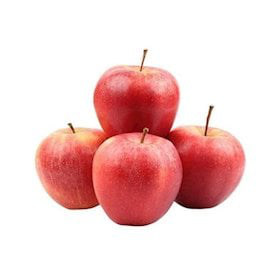

In [72]:
Image.open('alma.jpg')